In [226]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from timeit import default_timer as timer
from helper_functions import accuracy_fn

In [4]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

## 5.

In [6]:
train_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [8]:
len(train_data)

60000

In [10]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [12]:
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [14]:
len(test_data)

10000

In [16]:
image, label = train_data[0]

In [18]:
image.shape

torch.Size([1, 28, 28])

In [20]:
random_idx = torch.randint(0, len(train_data), size=[5])
random_idx

tensor([34594, 54341, 17536, 13554,  4950])

## 6.

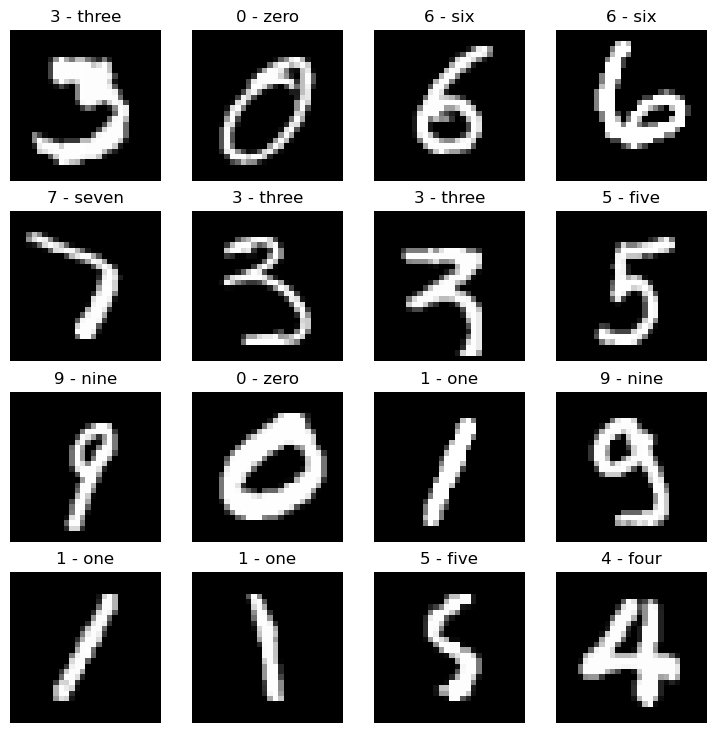

In [22]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

## 7.

In [24]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                         batch_size=32,
                                         shuffle=True)
len(train_dataloader)

1875

In [26]:
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                             batch_size=32)
len(test_dataloader)

313

## 8.

In [28]:
class TinyVGG(nn.Module):
    def __init__(self, in_shape, hidden_units, out_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)            
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, 
                      out_features=out_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [30]:
model_2 = TinyVGG(in_shape=1,
                 hidden_units=10,
                 out_shape=len(class_names)).to(device)
model_2

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [34]:
random_tensor = torch.randn(size=(1,1,28,28)).to(device)
random_tensor.shape

torch.Size([1, 1, 28, 28])

In [36]:
model_2(random_tensor)

tensor([[ 0.0074,  0.0246, -0.0272,  0.0218, -0.0151, -0.0589, -0.0238, -0.0161,
         -0.0019, -0.0026]], device='mps:0', grad_fn=<LinearBackward0>)

## 9.

In [37]:
def train_step(model:nn.Module,
               loss_fn:nn.Module,
               optimizer:torch.optim,
               dataloader:torch.utils.data.DataLoader,
               accuracy_fn=accuracy_fn,
               device=device):
    
    train_loss = 0
    train_acc = 0
    
    model.to(device)
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=torch.argmax(y_pred, dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [38]:
def test_step(model:nn.Module,
               loss_fn:nn.Module,
               dataloader:torch.utils.data.DataLoader,
               accuracy_fn=accuracy_fn,
               device=device):

    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred, y)
            test_loss += loss
            test_acc += accuracy_fn(y_true=y, y_pred=torch.argmax(test_pred, dim=1))

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")

In [42]:
from fastprogress.fastprogress import progress_bar

In [44]:
def print_train_time(start: float, end: float, device: torch.device = None):
    """ prints difference between start and end time"""
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")

In [46]:
start_time_gpu = timer()
epochs = 3

for epoch in progress_bar(range(epochs)):
    print(f"Epoch:{epoch}\n------------")

    train_step(model=model_2,
              loss_fn=loss_fn,
              optimizer=optimizer,
              dataloader=train_dataloader)

    test_step(model=model_2, 
             loss_fn=loss_fn,
             dataloader=test_dataloader)

stop_train_time = timer()
print_train_time(start_time_gpu, stop_train_time, device)


Epoch:0
------------
Train loss: 0.22799 | Train acc: 92.53%
Test loss: 0.06607 | Test acc: 97.87%
Epoch:1
------------
Train loss: 0.06832 | Train acc: 97.92%
Test loss: 0.05029 | Test acc: 98.37%
Epoch:2
------------
Train loss: 0.05367 | Train acc: 98.33%
Test loss: 0.04979 | Test acc: 98.38%
Train time on mps: 21.045 seconds


## 10.

In [47]:
def make_predictions(model:nn.Module,
                    data: list,
                    device=device):
    pred_probs = []
    
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = sample.unsqueeze(0).to(device)
            
            y_logits = model(sample)
            y_pred_prob = torch.softmax(y_logits.squeeze(), dim=0)
            pred_probs.append(y_pred_prob.cpu())
            
    print(pred_probs)
    return torch.stack(pred_probs)

In [192]:
import random
test_X = []
test_y = []

for X, y in random.sample(list(test_data), k=9):
    test_X.append(X)
    test_y.append(y)

test_X[0].shape

torch.Size([1, 28, 28])

In [194]:
sample_pred_probs = make_predictions(model=model_2, 
                                    data=test_X)
sample_pred_probs,

[tensor([1.6050e-06, 9.9899e-01, 9.8121e-06, 6.1039e-08, 7.9743e-04, 9.4086e-09,
        8.5517e-08, 1.6031e-04, 1.5602e-05, 2.4586e-05]), tensor([1.9048e-08, 6.8995e-08, 2.1124e-09, 5.1320e-11, 4.9253e-05, 3.3170e-06,
        9.9994e-01, 2.5408e-11, 8.7802e-06, 1.1384e-09]), tensor([3.8293e-09, 1.5540e-08, 9.9914e-01, 7.9615e-04, 1.5794e-09, 3.8477e-08,
        4.1550e-10, 6.2290e-05, 8.0403e-09, 4.0954e-08]), tensor([4.8567e-07, 1.5295e-06, 1.0000e+00, 2.4577e-08, 2.0064e-11, 6.4273e-15,
        6.7798e-13, 2.5216e-08, 1.8834e-09, 2.7332e-11]), tensor([1.5371e-09, 1.8012e-11, 1.0123e-10, 1.5777e-12, 1.7743e-09, 5.5638e-06,
        9.9999e-01, 5.9201e-14, 2.1544e-09, 5.2281e-12]), tensor([4.8720e-09, 1.5037e-08, 7.1185e-09, 9.9892e-01, 4.0396e-11, 9.9774e-04,
        5.7852e-08, 3.3289e-10, 8.7604e-06, 7.6643e-05]), tensor([2.6998e-08, 1.5676e-06, 3.9047e-03, 7.0632e-04, 3.9061e-08, 9.0444e-06,
        7.2875e-10, 1.0970e-03, 9.9424e-01, 4.2523e-05]), tensor([9.9980e-01, 1.6316e-10, 5

(tensor([[1.6050e-06, 9.9899e-01, 9.8121e-06, 6.1039e-08, 7.9743e-04, 9.4086e-09,
          8.5517e-08, 1.6031e-04, 1.5602e-05, 2.4586e-05],
         [1.9048e-08, 6.8995e-08, 2.1124e-09, 5.1320e-11, 4.9253e-05, 3.3170e-06,
          9.9994e-01, 2.5408e-11, 8.7802e-06, 1.1384e-09],
         [3.8293e-09, 1.5540e-08, 9.9914e-01, 7.9615e-04, 1.5794e-09, 3.8477e-08,
          4.1550e-10, 6.2290e-05, 8.0403e-09, 4.0954e-08],
         [4.8567e-07, 1.5295e-06, 1.0000e+00, 2.4577e-08, 2.0064e-11, 6.4273e-15,
          6.7798e-13, 2.5216e-08, 1.8834e-09, 2.7332e-11],
         [1.5371e-09, 1.8012e-11, 1.0123e-10, 1.5777e-12, 1.7743e-09, 5.5638e-06,
          9.9999e-01, 5.9201e-14, 2.1544e-09, 5.2281e-12],
         [4.8720e-09, 1.5037e-08, 7.1185e-09, 9.9892e-01, 4.0396e-11, 9.9774e-04,
          5.7852e-08, 3.3289e-10, 8.7604e-06, 7.6643e-05],
         [2.6998e-08, 1.5676e-06, 3.9047e-03, 7.0632e-04, 3.9061e-08, 9.0444e-06,
          7.2875e-10, 1.0970e-03, 9.9424e-01, 4.2523e-05],
         [9.9

In [176]:
sample_pred_labels = torch.argmax(sample_pred_probs, dim=1)
sample_pred_labels

tensor([2, 2, 5, 0, 9, 4, 7, 3, 5])

In [178]:
test_y

[2, 2, 5, 0, 9, 4, 7, 3, 5]

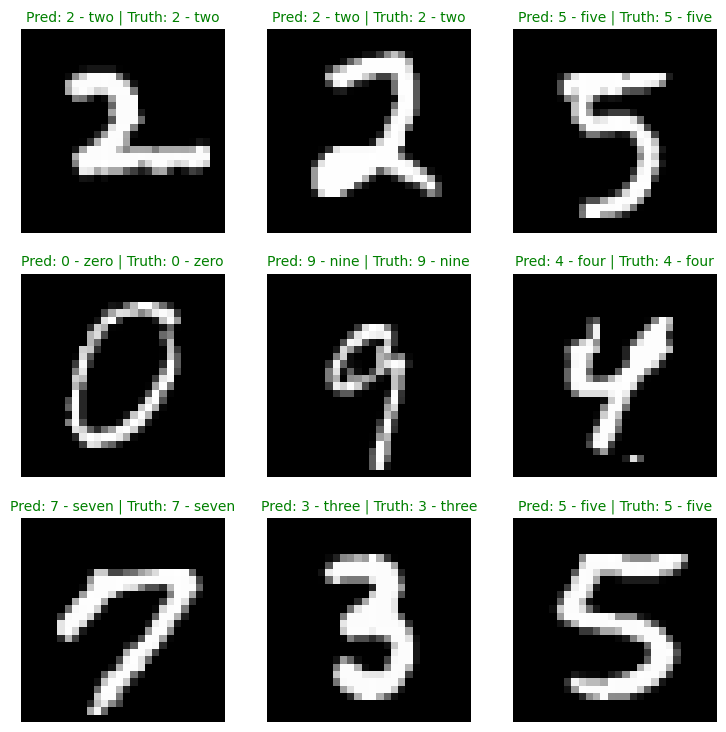

In [180]:
plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_X):
    # Create subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    plt.imshow(sample.squeeze(), cmap="gray")

    # Find the prediction label (in text form)
    pred_label = class_names[sample_pred_labels[i]]

    # Get the truth label
    truth_label = class_names[test_y[i]]

    # Create title for the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if pred is correct
    else:
        plt.title(title_text, fontsize=10, c="r")
    plt.axis(False)

In [64]:
pred_labels = []
model_2.to(device)
model_2.eval()
with torch.inference_mode():
    for X, y in (test_dataloader):
        X, y = X.to(device), y.to(device)
        pred_label = torch.argmax(model_2(X), dim=1)
        pred_labels.append(pred_label)
pred_labels

[tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
         4, 0, 7, 4, 0, 1, 3, 1], device='mps:0'),
 tensor([3, 0, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0,
         4, 1, 9, 5, 7, 8, 9, 3], device='mps:0'),
 tensor([7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 8, 7, 7, 6, 2, 7, 8, 4, 7, 3,
         6, 1, 3, 6, 9, 3, 1, 4], device='mps:0'),
 tensor([1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
         5, 4, 7, 6, 7, 9, 0, 5], device='mps:0'),
 tensor([8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9,
         5, 5, 1, 5, 6, 0, 3, 4], device='mps:0'),
 tensor([4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0,
         8, 9, 2, 5, 0, 1, 1, 1], device='mps:0'),
 tensor([0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0,
         3, 6, 5, 5, 7, 2, 2, 7], device='mps:0'),
 tensor([1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0

## 11.

In [ ]:
pred_labels = torch.cat(pred_labels)

In [78]:
pred_labels, test_data.targets

(tensor([7, 2, 1,  ..., 4, 5, 6], device='mps:0'),
 tensor([7, 2, 1,  ..., 4, 5, 6]))

In [142]:
import torchmetrics
from torchmetrics import ConfusionMatrix
import numpy as np

In [112]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to(device)

In [124]:
targets = test_data.targets.to(device)
pred_labels = pred_labels.to(device)

In [128]:
confmat_tensor = confmat(pred_labels, targets)
confmat_tensor

tensor([[ 976,    0,    0,    0,    0,    0,    0,    1,    3,    0],
        [   0, 1128,    2,    0,    1,    1,    1,    0,    2,    0],
        [   5,    0, 1018,    1,    0,    0,    0,    1,    7,    0],
        [   1,    0,    3,  996,    0,    7,    0,    0,    3,    0],
        [   1,    0,    1,    0,  974,    0,    2,    0,    2,    2],
        [   2,    0,    0,    5,    0,  880,    1,    0,    2,    2],
        [  11,    3,    0,    1,    3,    8,  926,    0,    5,    1],
        [   0,    4,   13,    1,    0,    1,    0, 1008,    1,    0],
        [   2,    0,    3,    1,    2,    1,    0,    0,  965,    0],
        [   1,    4,    0,    1,    5,    4,    0,    5,   22,  967]],
       device='mps:0')

In [134]:
from sklearn.metrics import ConfusionMatrixDisplay

In [150]:
confmat_tensor = confmat_tensor.cpu()

In [212]:
display_labels = []
for label in test_data.classes:
    display_labels.append(label.split("-"))
display_labels = np.array(display_labels)

In [220]:
display_labels = display_labels[:,0]

In [222]:
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(confmat_tensor), display_labels=display_labels)

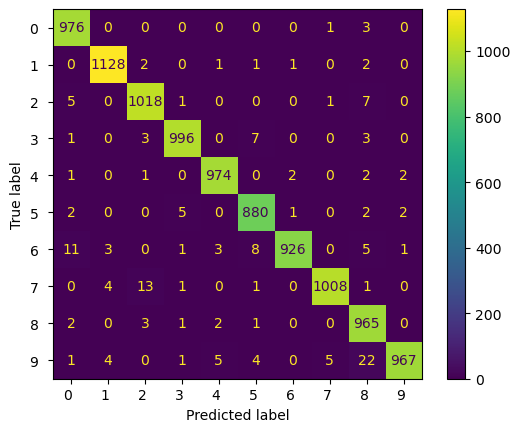

In [224]:
disp.plot()